# Network Intrusion Detection with Machine Learning

## PART 1: SETUP AND DATA LOADING

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, make_scorer, roc_curve, auc)
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from scipy import stats
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('traffic_log.csv')

# Set style for all plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## PART 2: DATA EXPLORATION AND ANALYSIS

In [78]:
print(f"Dataset shape: {df.shape}")
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")

Dataset shape: (65532, 12)
Total records: 65,532
Total features: 12


In [79]:
print("Data types and missing values:")
df.isnull().sum()

Data types and missing values:


Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [80]:
print("Target Variable Distribution:")
action_counts = df['Action'].value_counts()
for action, count in action_counts.items():
    print(f"  {action}: {count:,} ({count/len(df)*100:.1f}%)")

Target Variable Distribution:
  allow: 37,640 (57.4%)
  deny: 14,987 (22.9%)
  drop: 12,851 (19.6%)
  reset-both: 54 (0.1%)


In [81]:
df['label'] = df['Action'].apply(lambda x: 0 if x == 'allow' else 1)
print("Binary Classification Setup:")
print(f"  Normal traffic (0): {(df['label']==0).sum():,} ({(df['label']==0).sum()/len(df)*100:.1f}%)")
print(f"  Suspicious traffic (1): {(df['label']==1).sum():,} ({(df['label']==1).sum()/len(df)*100:.1f}%)")

Binary Classification Setup:
  Normal traffic (0): 37,640 (57.4%)
  Suspicious traffic (1): 27,892 (42.6%)


In [82]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('label')

print("Feature Statistics Summary:")
stats_df = df[numeric_cols].describe().T
stats_df['skew'] = df[numeric_cols].skew()
print(stats_df[['mean', 'std', 'min', 'max', 'skew']].round(2))

Feature Statistics Summary:
                          mean         std   min           max    skew
Source Port           49391.97    15255.71   0.0  6.553400e+04   -1.71
Destination Port      10577.39    18466.03   0.0  6.553500e+04    1.60
NAT Source Port       19282.97    21970.69   0.0  6.553500e+04    0.68
NAT Destination Port   2671.05     9739.16   0.0  6.553500e+04    4.19
Bytes                 97123.95  5618438.91  60.0  1.269359e+09  187.29
Bytes Sent            22385.80  3828138.65  60.0  9.484772e+08  235.23
Bytes Received        74738.15  2463207.71   0.0  3.208818e+08   93.65
Packets                 102.87     5133.00   1.0  1.036116e+06  158.89
Elapsed Time (sec)       65.83      302.46   0.0  1.082400e+04   12.45
pkts_sent                41.40     3218.87   1.0  7.475200e+05  205.20
pkts_received            61.47     2223.33   0.0  3.272080e+05  106.71


## PART 3: CORRELATION ANALYSIS

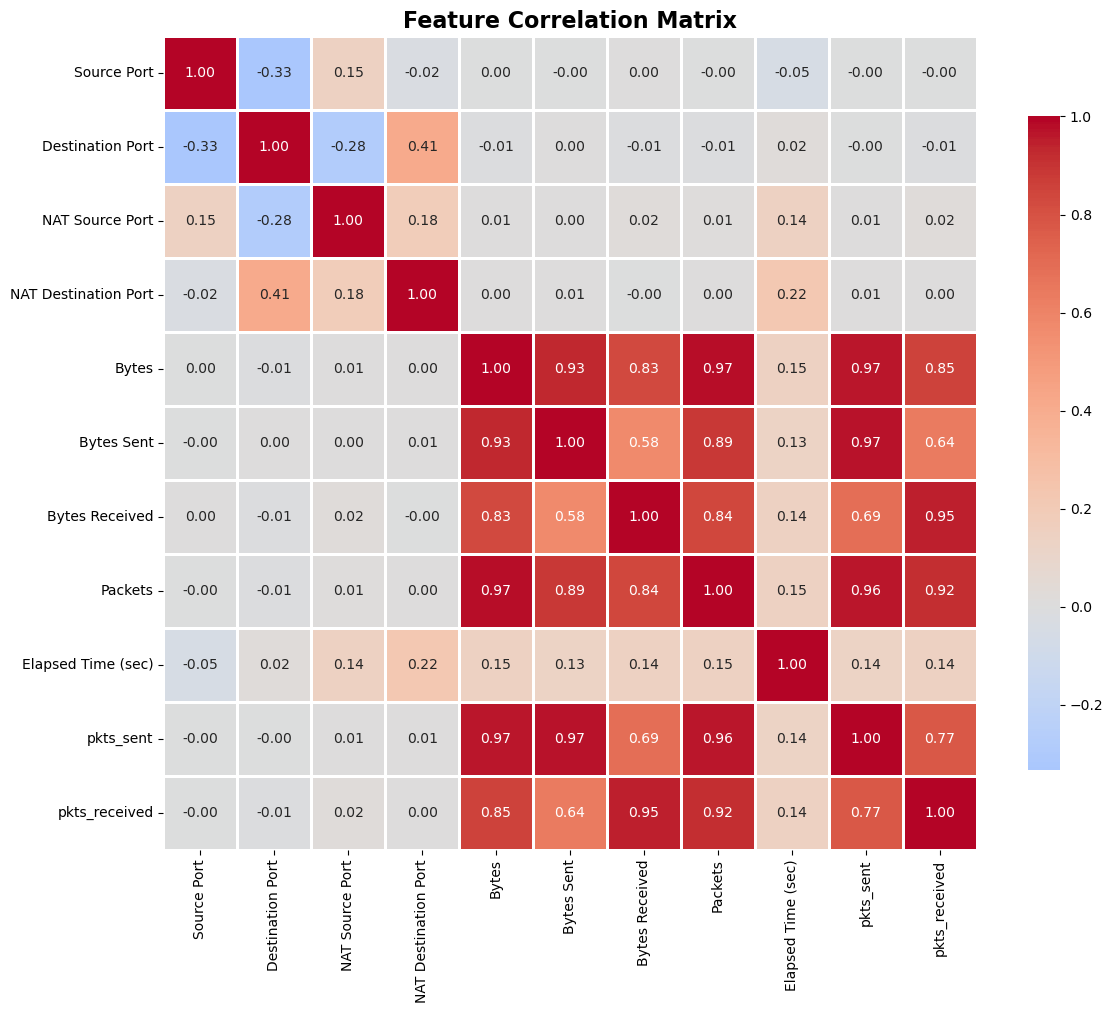

In [83]:
corr_matrix = df[numeric_cols].corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [84]:
# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("Highly correlated feature pairs (|corr| > 0.7):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

Highly correlated feature pairs (|corr| > 0.7):
  Bytes <-> Bytes Sent: 0.933
  Bytes <-> Bytes Received: 0.830
  Bytes <-> Packets: 0.974
  Bytes <-> pkts_sent: 0.967
  Bytes <-> pkts_received: 0.850
  Bytes Sent <-> Packets: 0.888
  Bytes Sent <-> pkts_sent: 0.974
  Bytes Received <-> Packets: 0.843
  Bytes Received <-> pkts_received: 0.946
  Packets <-> pkts_sent: 0.961
  Packets <-> pkts_received: 0.917
  pkts_sent <-> pkts_received: 0.772


## PART 4: FEATURE ENGINEERING

In [85]:
# Create new features directly
df_feat = df.copy()

# 1. Byte ratio features
df_feat['byte_ratio'] = df_feat['Bytes Sent'] / (df_feat['Bytes Received'] + 1)
df_feat['packet_ratio'] = df_feat['pkts_sent'] / (df_feat['pkts_received'] + 1)

# 2. Average bytes per packet
df_feat['avg_bytes_per_packet'] = df_feat['Bytes'] / (df_feat['Packets'] + 1)
df_feat['avg_bytes_sent_per_packet'] = df_feat['Bytes Sent'] / (df_feat['pkts_sent'] + 1)
df_feat['avg_bytes_recv_per_packet'] = df_feat['Bytes Received'] / (df_feat['pkts_received'] + 1)

# 3. Time-based features
df_feat['bytes_per_second'] = df_feat['Bytes'] / (df_feat['Elapsed Time (sec)'] + 1)
df_feat['packets_per_second'] = df_feat['Packets'] / (df_feat['Elapsed Time (sec)'] + 1)

# 4. Port-based features
service_ports = [20, 21, 22, 23, 25, 53, 80, 110, 143, 443, 445, 3306, 3389, 8080]
df_feat['is_common_port'] = df_feat['Destination Port'].isin(service_ports).astype(int)
df_feat['is_high_src_port'] = (df_feat['Source Port'] > 1024).astype(int)
df_feat['is_high_dst_port'] = (df_feat['Destination Port'] > 1024).astype(int)
df_feat['is_http'] = df_feat['Destination Port'].isin([80, 8080, 443]).astype(int)
df_feat['is_dns'] = (df_feat['Destination Port'] == 53).astype(int)
df_feat['is_ssh'] = (df_feat['Destination Port'] == 22).astype(int)
df_feat['is_rdp'] = (df_feat['Destination Port'] == 3389).astype(int)

# 5. NAT difference features
df_feat['src_port_changed'] = (df_feat['Source Port'] != df_feat['NAT Source Port']).astype(int)
df_feat['dst_port_changed'] = (df_feat['Destination Port'] != df_feat['NAT Destination Port']).astype(int)

# 6. Anomaly indicators
df_feat['zero_bytes'] = (df_feat['Bytes'] == 0).astype(int)
df_feat['single_packet'] = (df_feat['Packets'] == 1).astype(int)
df_feat['unbalanced_flow'] = (abs(df_feat['pkts_sent'] - df_feat['pkts_received']) > 5).astype(int)

# Handle infinities and missing values
df_engineered = df_feat.replace([np.inf, -np.inf], np.nan)
df_engineered = df_engineered.fillna(0)

# Show new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"Created {len(new_features)} new features")

Created 19 new features


In [86]:
# Feature importance by correlation with target
numeric_features = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('label')

correlations = []
for feat in numeric_features:
    corr = df_engineered[feat].corr(df_engineered['label'])
    correlations.append((feat, abs(corr)))
correlations.sort(key=lambda x: x[1], reverse=True)

print("Top 10 features by correlation with target:")
for i, (feat, corr) in enumerate(correlations[:10], 1):
    print(f"  {i:2}. {feat:30} | Correlation: {corr:.4f}")

Top 10 features by correlation with target:
   1. dst_port_changed               | Correlation: 0.9816
   2. NAT Source Port                | Correlation: 0.7543
   3. is_http                        | Correlation: 0.4830
   4. is_dns                         | Correlation: 0.4753
   5. avg_bytes_recv_per_packet      | Correlation: 0.4262
   6. avg_bytes_per_packet           | Correlation: 0.4206
   7. is_common_port                 | Correlation: 0.3733
   8. is_high_dst_port               | Correlation: 0.3719
   9. Destination Port               | Correlation: 0.3680
  10. avg_bytes_sent_per_packet      | Correlation: 0.3329


## PART 5: DATA PREPARATION

In [87]:
# Select features and split data
features_to_use = [col for col in numeric_features if col != 'Action']
X = df_engineered[features_to_use]
y = df_engineered['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

Train set: 52,425 samples
Test set: 13,107 samples
Features: 30


## PART 6: BASELINE MODELS

In [88]:
# Dummy Classifier (Majority Class)
print("DUMMY CLASSIFIER (Majority Class Baseline):")
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_precision = precision_score(y_test, y_pred_dummy, zero_division=0)
dummy_recall = recall_score(y_test, y_pred_dummy)
dummy_f1 = f1_score(y_test, y_pred_dummy)

print(f"  Accuracy:  {dummy_accuracy:.4f}")
print(f"  Precision: {dummy_precision:.4f}")
print(f"  Recall:    {dummy_recall:.4f}")
print(f"  F1-Score:  {dummy_f1:.4f}")

DUMMY CLASSIFIER (Majority Class Baseline):
  Accuracy:  0.5743
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000


In [89]:
# Simple Logistic Regression Baseline (No SMOTE, No Tuning)
print("SIMPLE LOGISTIC REGRESSION BASELINE:")

lr_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

lr_baseline.fit(X_train, y_train)
y_pred_lr_base = lr_baseline.predict(X_test)
y_pred_lr_base_proba = lr_baseline.predict_proba(X_test)[:, 1]

lr_base_accuracy = accuracy_score(y_test, y_pred_lr_base)
lr_base_precision = precision_score(y_test, y_pred_lr_base)
lr_base_recall = recall_score(y_test, y_pred_lr_base)
lr_base_f1 = f1_score(y_test, y_pred_lr_base)
lr_base_auc = roc_auc_score(y_test, y_pred_lr_base_proba)

print(f"  Accuracy:  {lr_base_accuracy:.4f}")
print(f"  Precision: {lr_base_precision:.4f}")
print(f"  Recall:    {lr_base_recall:.4f}")
print(f"  F1-Score:  {lr_base_f1:.4f}")
print(f"  AUC-ROC:   {lr_base_auc:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr_base, 
                          target_names=['Normal', 'Attack'],
                          digits=4))

SIMPLE LOGISTIC REGRESSION BASELINE:
  Accuracy:  0.9978
  Precision: 0.9964
  Recall:    0.9984
  F1-Score:  0.9974
  AUC-ROC:   1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal     0.9988    0.9973    0.9981      7528
      Attack     0.9964    0.9984    0.9974      5579

    accuracy                         0.9978     13107
   macro avg     0.9976    0.9979    0.9977     13107
weighted avg     0.9978    0.9978    0.9978     13107



In [90]:
print("BASELINE COMPARISON")
baseline_results = pd.DataFrame({
    'Model': ['Dummy (Majority)', 'LR Baseline (No Optimization)'],
    'F1-Score': [dummy_f1, lr_base_f1],
    'Accuracy': [dummy_accuracy, lr_base_accuracy],
    'Precision': [dummy_precision, lr_base_precision],
    'Recall': [dummy_recall, lr_base_recall]
})
print(baseline_results.to_string(index=False))

BASELINE COMPARISON
                        Model  F1-Score  Accuracy  Precision   Recall
             Dummy (Majority)  0.000000  0.574350   0.000000 0.000000
LR Baseline (No Optimization)  0.997404  0.997787   0.996422 0.998387


In [91]:
print("IMPROVEMENT OVER BASELINE")

print(f"Dummy Baseline F1: {dummy_f1:.4f}")
print(f"Simple LR Baseline F1: {lr_base_f1:.4f}")

IMPROVEMENT OVER BASELINE
Dummy Baseline F1: 0.0000
Simple LR Baseline F1: 0.9974


## PART 7: MODEL TRAINING AND EVALUATION

Training models...

Training Logistic Regression...
------------------------------
Training time: 0.11 seconds
Performance Metrics:
  Accuracy:  0.9978
  Precision: 0.9964
  Recall:    0.9984
  F1-Score:  0.9974
  AUC-ROC:   1.0000

Training Random Forest...
------------------------------
Training time: 0.31 seconds
Performance Metrics:
  Accuracy:  0.9996
  Precision: 0.9993
  Recall:    0.9998
  F1-Score:  0.9996
  AUC-ROC:   1.0000

Training XGBoost...
------------------------------
Training time: 0.06 seconds
Performance Metrics:
  Accuracy:  0.9993
  Precision: 0.9991
  Recall:    0.9993
  F1-Score:  0.9992
  AUC-ROC:   1.0000

Training SVM...
------------------------------
Training time: 0.32 seconds
Performance Metrics:
  Accuracy:  0.9972
  Precision: 0.9962
  Recall:    0.9971
  F1-Score:  0.9967
  AUC-ROC:   0.9997


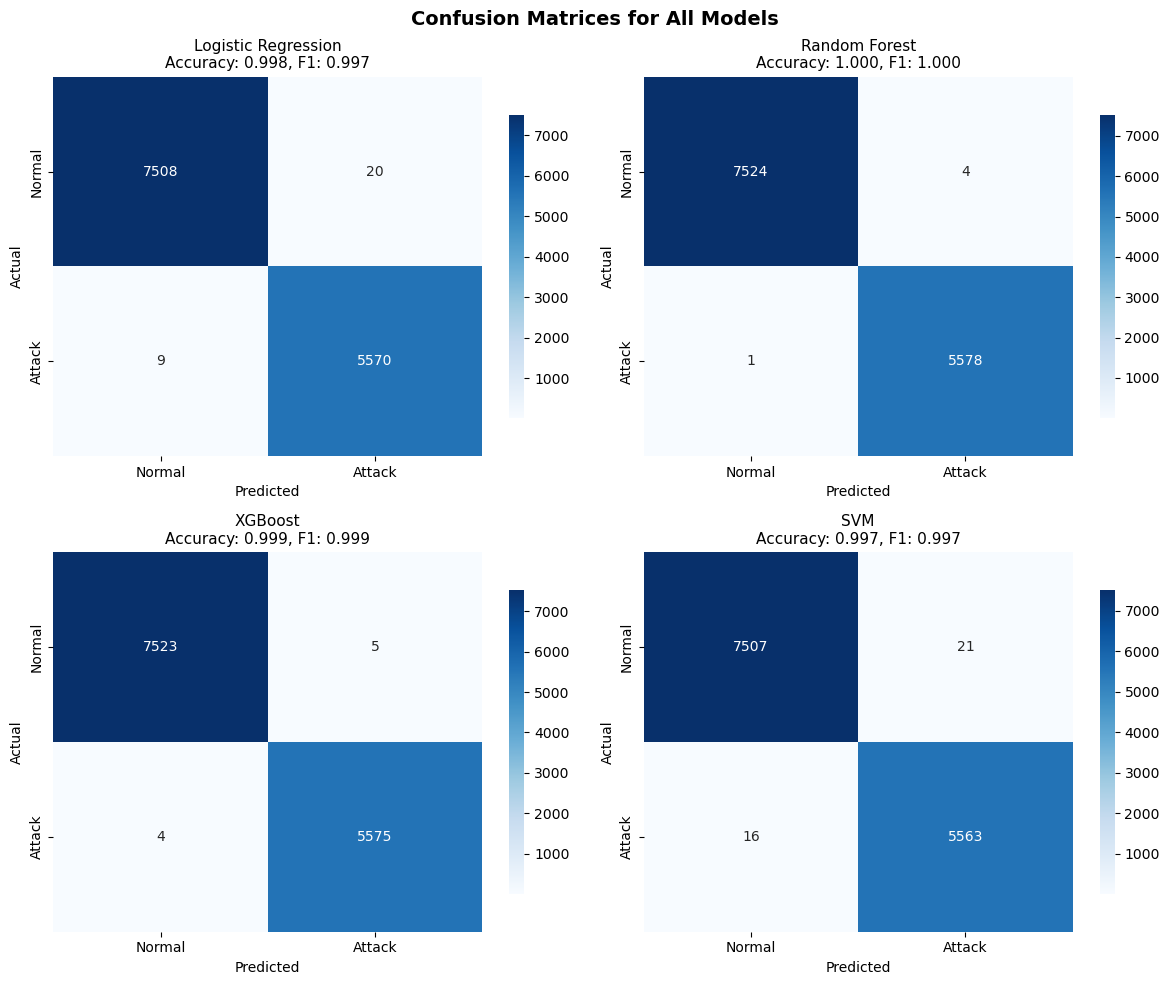

In [92]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

# Store results
results = []
confusion_matrices = {}

# Create figure for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

print("Training models...")

# Train and evaluate each model
for idx, (name, model) in enumerate(models.items()):
    print(f"\nTraining {name}...")
    print(f"{'-'*30}")
    
    start_time = time.time()
    
    # Train the model
    if name == 'SVM':
        sample_size = min(10000, len(X_train_scaled))
        indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
        X_train_subset = X_train_scaled[indices]
        y_train_subset = y_train.iloc[indices]
        model.fit(X_train_subset, y_train_subset)
    else:
        model.fit(X_train_scaled, y_train)
    
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'Train Time (s)': train_time
    })
    
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Performance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_roc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'],
                cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy:.3f}, F1: {f1:.3f}', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.suptitle('Confusion Matrices for All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [93]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model}")
print(f"  - F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"  - AUC-ROC: {results_df.iloc[0]['AUC-ROC']:.4f}")

              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC  Train Time (s)
      Random Forest  0.999619   0.999283 0.999821  0.999552 0.999999        0.305836
            XGBoost  0.999313   0.999104 0.999283  0.999193 0.999999        0.063805
Logistic Regression  0.997787   0.996422 0.998387  0.997404 0.999983        0.111422
                SVM  0.997177   0.996239 0.997132  0.996685 0.999662        0.319057

Best performing model: Random Forest
  - F1-Score: 0.9996
  - AUC-ROC: 1.0000


## PART 8: CROSS-VALIDATION ANALYSIS

Cross-validating...

Cross-validating Logistic Regression...
  F1 Scores: [0.9966 0.9973 0.9973 0.998  0.9982]
  Mean F1: 0.9975 (+/- 0.0011)

Cross-validating Random Forest...
  F1 Scores: [0.9993 1.     0.9996 1.     0.9999]
  Mean F1: 0.9998 (+/- 0.0005)

Cross-validating XGBoost...
  F1 Scores: [0.9993 1.     0.9999 0.9999 0.9999]
  Mean F1: 0.9998 (+/- 0.0005)

Cross-validating SVM...
  (Using 5000 samples for SVM)
  F1 Scores: [0.9943 1.     0.9989 0.9943 0.9977]
  Mean F1: 0.9970 (+/- 0.0047)


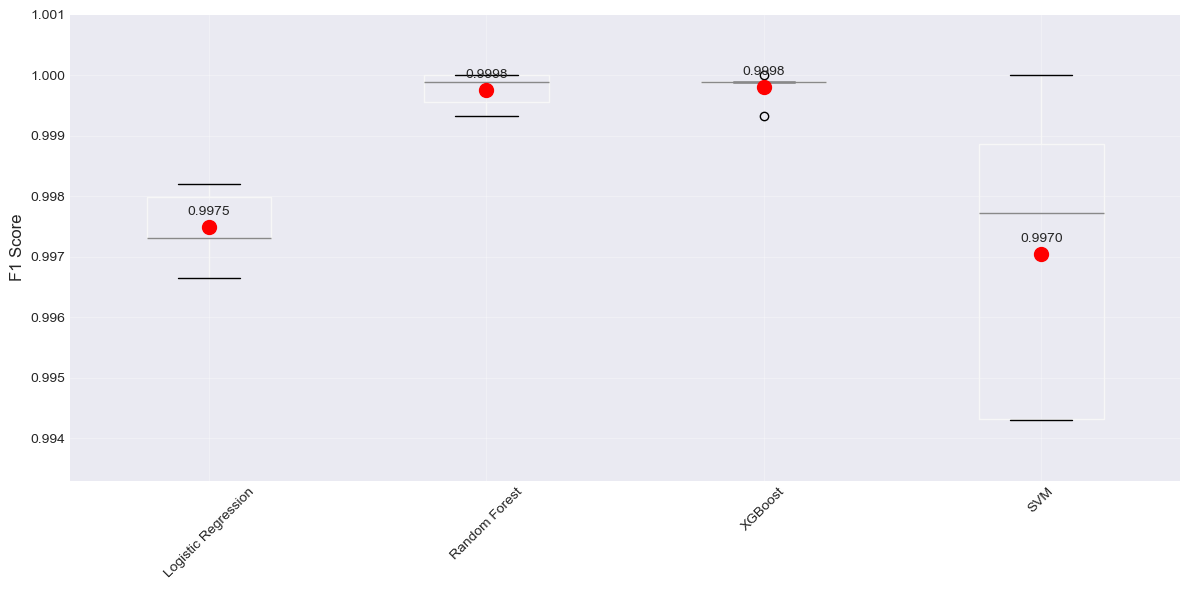

In [130]:
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)
print(f"Cross-validating...")

# Each pipeline ensures scaling happens WITHIN each CV fold
cv_pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),  # RF doesn't need scaling but doesn't hurt
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', xgb.XGBClassifier(n_estimators=100, random_state=42))
    ]),
    
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

cv_results = {}
for name, pipeline in cv_pipelines.items():
    print(f"\nCross-validating {name}...")
    
    # For SVM, use a subset due to computational cost
    if name == 'SVM':
        sample_size = min(5000, len(X_train))
        np.random.seed(42)
        indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_cv = X_train.iloc[indices]
        y_cv = y_train.iloc[indices]
        print(f"  (Using {sample_size} samples for SVM)")
    else:
        X_cv = X_train  # Use raw, unscaled data
        y_cv = y_train
    
    # Perform cross-validation with pipeline
    scores = cross_val_score(pipeline, X_cv, y_cv, 
                           cv=cv_folds, scoring=f1_scorer, n_jobs=-1)
    cv_results[name] = scores
    print(f"  F1 Scores: {scores.round(4)}")
    print(f"  Mean F1: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Plot CV results
plt.figure(figsize=(12, 6))
cv_df = pd.DataFrame(cv_results)
box_plot = cv_df.boxplot(grid=False)
plt.ylabel('F1 Score', fontsize=12)
#plt.title('5-Fold Cross-Validation Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for i, col in enumerate(cv_df.columns, 1):
    plt.scatter(i, cv_df[col].mean(), color='red', s=100, zorder=5)
    plt.text(i, cv_df[col].mean() + 0.0002, f'{cv_df[col].mean():.4f}', 
             ha='center', fontsize=10)

y_min = cv_df.min().min() - 0.001
y_max = cv_df.max().max() + 0.001
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

## PART 9: MODEL OPTIMIZATION WITH SMOTE

In [95]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {len(y_train)} samples")
print(f"Balanced training set: {len(y_train_balanced)} samples")
print(f"  - Normal: {(y_train_balanced==0).sum()}")
print(f"  - Suspicious: {(y_train_balanced==1).sum()}")

Original training set: 52425 samples
Balanced training set: 60224 samples
  - Normal: 30112
  - Suspicious: 30112


In [96]:
# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 9],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    }
}

# Hyperparameter tuning for all models
print("Hyperparameter Tuning for All Models...")

# Store best models and scores
best_models = {}
tuning_results = []

for name, config in param_grids.items():
    print(f"\nTuning {name}...")
    
    # For SVM, use a smaller subset due to computational cost
    if name == 'SVM':
        sample_size = min(5000, len(X_train_balanced))
        indices = np.random.choice(len(X_train_balanced), sample_size, replace=False)
        X_tune = X_train_balanced[indices]
        y_tune = y_train_balanced[indices]
        print(f"  Using {sample_size} samples for SVM tuning")
    else:
        X_tune = X_train_balanced
        y_tune = y_train_balanced
    
    # Grid search
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=3,  # 3-fold for faster tuning
        scoring=f1_scorer, 
        n_jobs=-1, 
        verbose=0
    )
    
    grid_search.fit(X_tune, y_tune)
    
    # Store best model
    best_models[name] = grid_search.best_estimator_
    
    # Evaluate on test set
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    tuning_results.append({
        'Model': name,
        'Best_Params': grid_search.best_params_,
        'CV_Score': grid_search.best_score_,
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_AUC': auc_roc
    })
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Best CV F1-Score: {grid_search.best_score_:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")

Hyperparameter Tuning for All Models...

Tuning Logistic Regression...
  Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
  Best CV F1-Score: 0.9993
  Test F1-Score: 0.9991

Tuning Random Forest...
  Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV F1-Score: 0.9999
  Test F1-Score: 0.9996

Tuning XGBoost...
  Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
  Best CV F1-Score: 0.9999
  Test F1-Score: 0.9992

Tuning SVM...
  Using 5000 samples for SVM tuning
  Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
  Best CV F1-Score: 0.9984
  Test F1-Score: 0.9959


In [97]:
results_df = pd.DataFrame(tuning_results)
print("Test Set Performance (After Tuning + SMOTE):")
print(results_df[['Model', 'Test_F1', 'Test_Accuracy', 'Test_Precision', 'Test_Recall']].to_string(index=False))

# Find best model
best_model_idx = results_df['Test_F1'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_f1 = results_df.loc[best_model_idx, 'Test_F1']

print(f"\nBest performing model after optimization: {best_model_name}")
print(f"  - F1-Score: {best_f1:.4f}")
print(f"  - Best parameters: {results_df.loc[best_model_idx, 'Best_Params']}")

Test Set Performance (After Tuning + SMOTE):
              Model  Test_F1  Test_Accuracy  Test_Precision  Test_Recall
Logistic Regression 0.999103       0.999237        0.999641     0.998566
      Random Forest 0.999552       0.999619        0.999283     0.999821
            XGBoost 0.999193       0.999313        0.999104     0.999283
                SVM 0.995880       0.996490        0.995167     0.996594

Best performing model after optimization: Random Forest
  - F1-Score: 0.9996
  - Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


## PART 10: FEATURE IMPORTANCE ANALYSIS

In [98]:
feature_names = X_train.columns

print("XGBoost Top 15 Features Importance:")
if 'XGBoost' in best_models:
    xgb_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_models['XGBoost'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    for i, row in xgb_importance.head(15).iterrows():
        print(f"  {row['Feature']:30} | Importance: {row['Importance']:.4f}")

XGBoost Top 15 Features Importance:
  Elapsed Time (sec)             | Importance: 0.9473
  Packets                        | Importance: 0.0256
  dst_port_changed               | Importance: 0.0206
  avg_bytes_per_packet           | Importance: 0.0022
  bytes_per_second               | Importance: 0.0012
  Bytes Sent                     | Importance: 0.0007
  src_port_changed               | Importance: 0.0006
  Bytes                          | Importance: 0.0005
  Destination Port               | Importance: 0.0004
  Source Port                    | Importance: 0.0002
  avg_bytes_sent_per_packet      | Importance: 0.0002
  Bytes Received                 | Importance: 0.0001
  avg_bytes_recv_per_packet      | Importance: 0.0001
  NAT Source Port                | Importance: 0.0001
  packet_ratio                   | Importance: 0.0001


In [99]:
print("Random Forest Top 15 Features Importance:")
if 'Random Forest' in best_models:
    rf_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_models['Random Forest'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    for i, row in rf_importance.head(15).iterrows():
        print(f"  {row['Feature']:30} | Importance: {row['Importance']:.4f}")

Random Forest Top 15 Features Importance:
  Elapsed Time (sec)             | Importance: 0.2060
  NAT Destination Port           | Importance: 0.1654
  NAT Source Port                | Importance: 0.1218
  single_packet                  | Importance: 0.1037
  Bytes Received                 | Importance: 0.0849
  Packets                        | Importance: 0.0694
  dst_port_changed               | Importance: 0.0482
  byte_ratio                     | Importance: 0.0447
  packets_per_second             | Importance: 0.0401
  avg_bytes_recv_per_packet      | Importance: 0.0331
  pkts_received                  | Importance: 0.0169
  Bytes                          | Importance: 0.0162
  bytes_per_second               | Importance: 0.0159
  Destination Port               | Importance: 0.0141
  avg_bytes_per_packet           | Importance: 0.0080


In [100]:
print("Logistic Regression Top 15 Features by Absolute Weights:")
if 'Logistic Regression' in best_models:
    # Get absolute values of coefficients for importance
    lr_coefs = np.abs(best_models['Logistic Regression'].coef_[0])
    lr_importance = pd.DataFrame({
        'Feature': feature_names,
        'Abs_Coefficient': lr_coefs,
        'Original_Coef': best_models['Logistic Regression'].coef_[0]
    }).sort_values('Abs_Coefficient', ascending=False)
    
    for i, row in lr_importance.head(15).iterrows():
        direction = "+" if row['Original_Coef'] > 0 else "-"
        print(f"  {row['Feature']:30} | Weight: {direction}{row['Abs_Coefficient']:.4f}")

Logistic Regression Top 15 Features by Absolute Weights:
  Elapsed Time (sec)             | Weight: -50.0374
  avg_bytes_per_packet           | Weight: +9.4714
  avg_bytes_recv_per_packet      | Weight: -9.1206
  dst_port_changed               | Weight: +6.7972
  avg_bytes_sent_per_packet      | Weight: -3.7073
  is_dns                         | Weight: -3.1759
  bytes_per_second               | Weight: -2.0489
  single_packet                  | Weight: +1.6704
  src_port_changed               | Weight: -1.4197
  NAT Destination Port           | Weight: -1.2160
  is_http                        | Weight: -1.0332
  unbalanced_flow                | Weight: -0.8537
  is_high_dst_port               | Weight: -0.8143
  NAT Source Port                | Weight: -0.7782
  Destination Port               | Weight: +0.6963


In [101]:
print("SVM Top 15 Features Importance (Permutation-based):")
if 'SVM' in best_models:
    
    # Use a subset for faster computation
    sample_size = min(5000, len(X_test_scaled))
    indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
    X_perm = X_test_scaled[indices]
    y_perm = y_test.iloc[indices]
    
    perm_importance = permutation_importance(
        best_models['SVM'], X_perm, y_perm, 
        n_repeats=10, random_state=42, scoring='f1'
    )
    
    svm_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    for i, row in svm_importance.head(15).iterrows():
        print(f"  {row['Feature']:30} | Importance: {row['Importance']:.4f} (±{row['Std']:.4f})")

SVM Top 15 Features Importance (Permutation-based):
  dst_port_changed               | Importance: 0.3800 (±0.0065)
  single_packet                  | Importance: 0.3312 (±0.0061)
  is_dns                         | Importance: 0.1242 (±0.0034)
  src_port_changed               | Importance: 0.0249 (±0.0017)
  NAT Destination Port           | Importance: 0.0148 (±0.0012)
  avg_bytes_recv_per_packet      | Importance: 0.0142 (±0.0014)
  Elapsed Time (sec)             | Importance: 0.0124 (±0.0009)
  avg_bytes_per_packet           | Importance: 0.0107 (±0.0012)
  avg_bytes_sent_per_packet      | Importance: 0.0067 (±0.0006)
  is_high_src_port               | Importance: 0.0018 (±0.0003)
  packet_ratio                   | Importance: 0.0018 (±0.0004)
  byte_ratio                     | Importance: 0.0018 (±0.0004)
  bytes_per_second               | Importance: 0.0013 (±0.0002)
  packets_per_second             | Importance: 0.0010 (±0.0003)
  Bytes Received                 | Importance: 0.000

In [102]:
# Normalize importances to 0-1 scale for each model
importance_dict = {}

if 'XGBoost' in best_models:
    xgb_norm = xgb_importance.copy()
    xgb_norm['Importance'] = xgb_norm['Importance'] / xgb_norm['Importance'].max()
    importance_dict['XGBoost'] = xgb_norm.set_index('Feature')['Importance']

if 'Random Forest' in best_models:
    rf_norm = rf_importance.copy()
    rf_norm['Importance'] = rf_norm['Importance'] / rf_norm['Importance'].max()
    importance_dict['Random Forest'] = rf_norm.set_index('Feature')['Importance']

if 'Logistic Regression' in best_models:
    lr_norm = lr_importance.copy()
    lr_norm['Normalized'] = lr_norm['Abs_Coefficient'] / lr_norm['Abs_Coefficient'].max()
    importance_dict['Logistic Regression'] = lr_norm.set_index('Feature')['Normalized']

if 'SVM' in best_models:
    svm_norm = svm_importance.copy()
    # Handle negative importances (make them 0)
    svm_norm['Importance'] = svm_norm['Importance'].clip(lower=0)
    if svm_norm['Importance'].max() > 0:
        svm_norm['Importance'] = svm_norm['Importance'] / svm_norm['Importance'].max()
    importance_dict['SVM'] = svm_norm.set_index('Feature')['Importance']

# Calculate average importance across all models
consensus_df = pd.DataFrame(importance_dict).fillna(0)
consensus_df['Average_Importance'] = consensus_df.mean(axis=1)
consensus_df = consensus_df.sort_values('Average_Importance', ascending=False)

print("Top 15 Features by Consensus Ranking:")
print("(Average normalized importance across all models)")
for i, (feature, row) in enumerate(consensus_df.head(15).iterrows(), 1):
    avg_imp = row['Average_Importance']
    print(f"  {i:2}. {feature:30} | Avg Importance: {avg_imp:.4f}")

Top 15 Features by Consensus Ranking:
(Average normalized importance across all models)
   1. Elapsed Time (sec)             | Avg Importance: 0.7582
   2. single_packet                  | Avg Importance: 0.3520
   3. dst_port_changed               | Avg Importance: 0.3479
   4. NAT Destination Port           | Avg Importance: 0.2165
   5. NAT Source Port                | Avg Importance: 0.1518
   6. Bytes Received                 | Avg Importance: 0.1036
   7. is_dns                         | Avg Importance: 0.0989
   8. avg_bytes_recv_per_packet      | Avg Importance: 0.0951
   9. Packets                        | Avg Importance: 0.0917
  10. avg_bytes_per_packet           | Avg Importance: 0.0646
  11. byte_ratio                     | Avg Importance: 0.0559
  12. packets_per_second             | Avg Importance: 0.0510
  13. bytes_per_second               | Avg Importance: 0.0307
  14. src_port_changed               | Avg Importance: 0.0238
  15. avg_bytes_sent_per_packet      | Avg I

## PART 11: COMPREHENSIVE VISUALIZATIONS

Creating Model Performance Comparison...


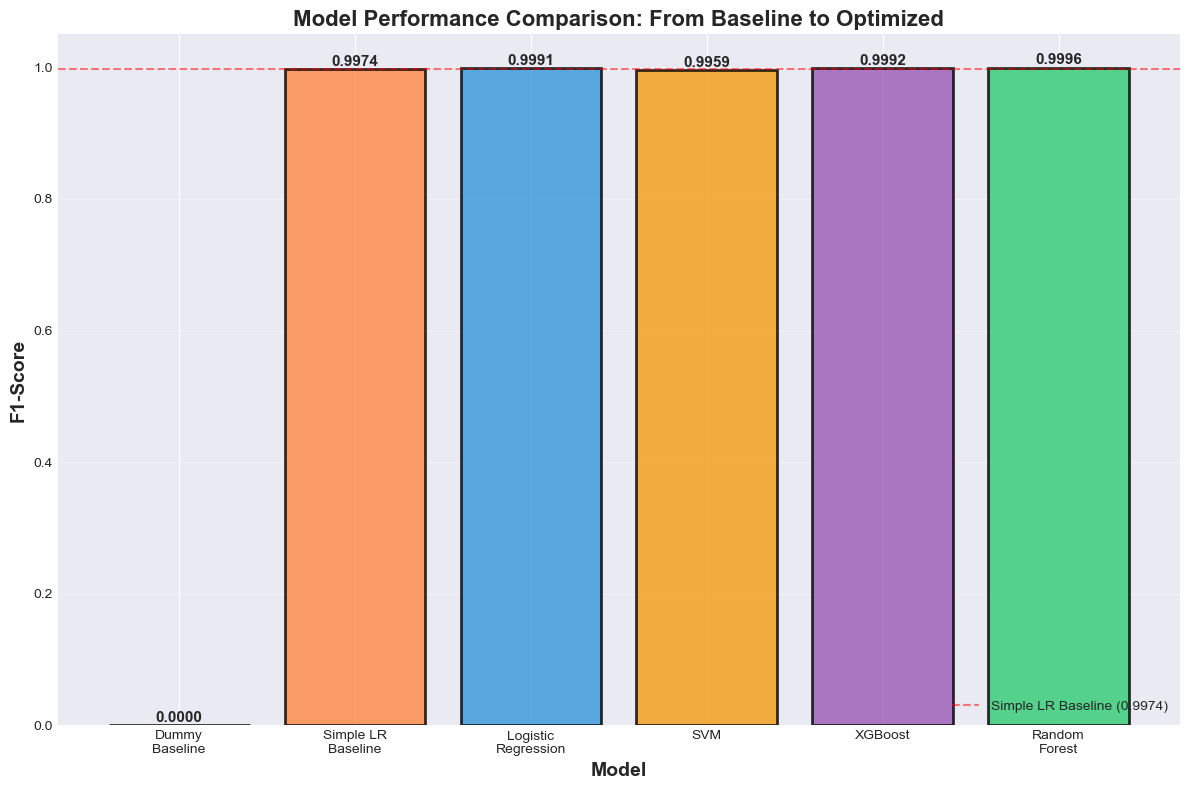

In [108]:
print("Creating Model Performance Comparison...")

plt.figure(figsize=(12, 8))

# Prepare data - use actual results from your models
model_names = ['Dummy\nBaseline', 'Simple LR\nBaseline', 'Logistic\nRegression', 
               'SVM', 'XGBoost', 'Random\nForest']

# Get actual F1 scores from your results
f1_scores = [
    dummy_f1,  # From baseline
    lr_base_f1,  # From baseline
    results_df[results_df['Model'] == 'Logistic Regression']['Test_F1'].values[0],
    results_df[results_df['Model'] == 'SVM']['Test_F1'].values[0],
    results_df[results_df['Model'] == 'XGBoost']['Test_F1'].values[0],
    results_df[results_df['Model'] == 'Random Forest']['Test_F1'].values[0]
]

colors = ['#ff4444', '#ff8844', '#3498db', '#f39c12', '#9b59b6', '#2ecc71']
bars = plt.bar(model_names, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f'{score:.4f}', ha='center', fontsize=11, fontweight='bold')

# Add a horizontal line for baseline reference
plt.axhline(y=lr_base_f1, color='red', linestyle='--', alpha=0.5, 
            label=f'Simple LR Baseline ({lr_base_f1:.4f})')

plt.ylabel('F1-Score', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.title('Model Performance Comparison: From Baseline to Optimized', fontsize=16, fontweight='bold')
plt.ylim([0, 1.05])
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Creating Feature Importance Visualization...


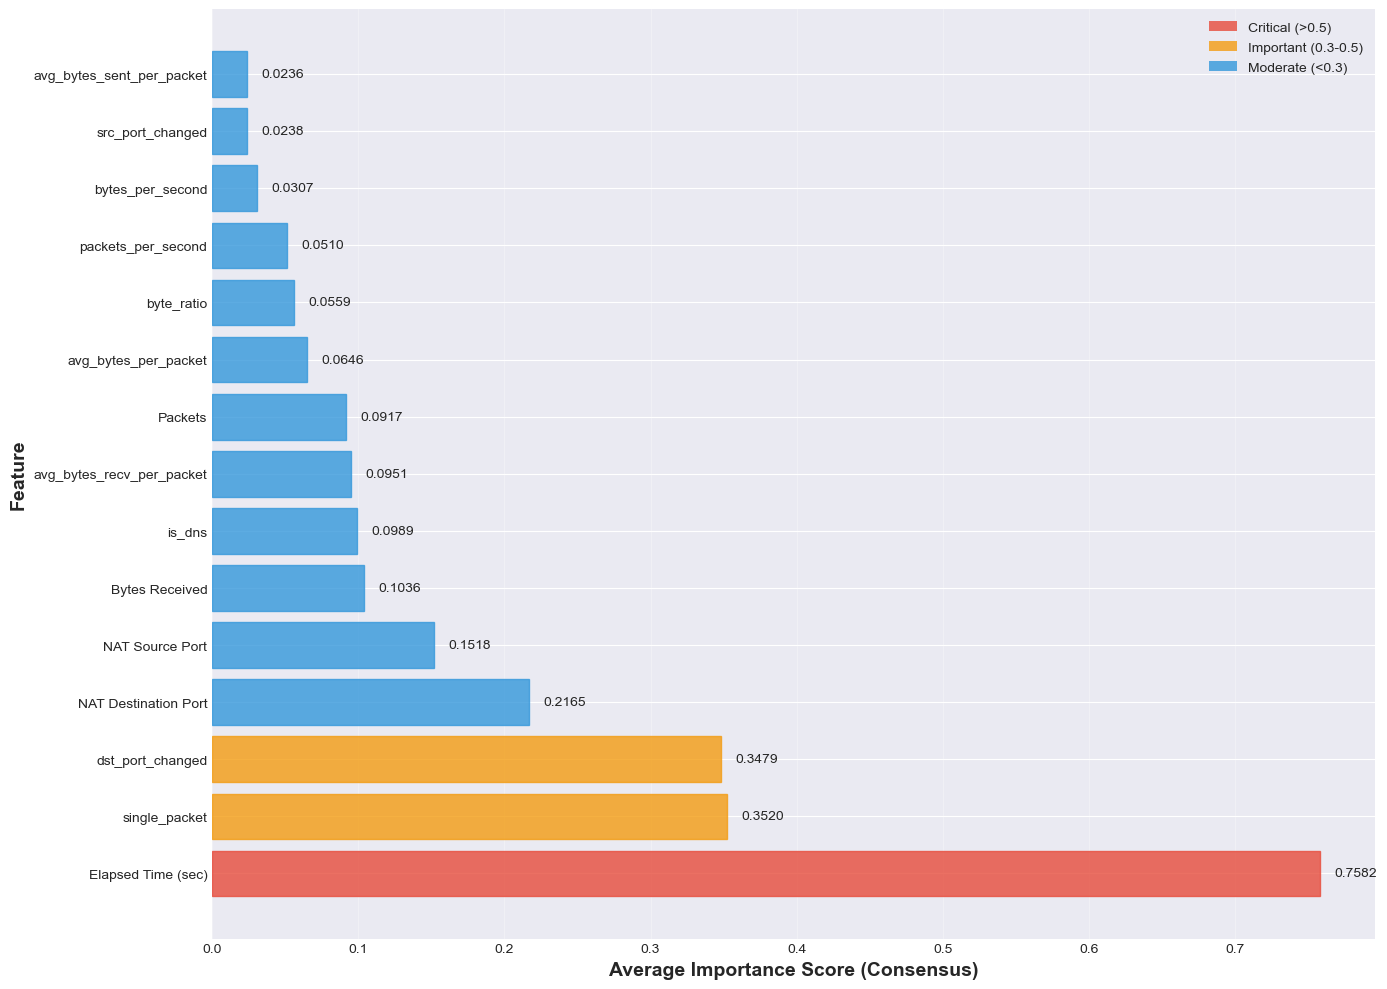

In [127]:
print("Creating Feature Importance Visualization...")

plt.figure(figsize=(14, 10))

# Get top 15 features from consensus ranking
top_features = consensus_df.head(15).index.tolist()
importance_values = consensus_df.head(15)['Average_Importance'].values

# Create horizontal bar chart
y_pos = np.arange(len(top_features))
bars = plt.barh(y_pos, importance_values, color='#9b59b6', alpha=0.8, edgecolor='black')

# Color bars by importance level
for i, (bar, val) in enumerate(zip(bars, importance_values)):
    if val > 0.5:
        bar.set_color('#e74c3c')  # Red for very important
    elif val > 0.3:
        bar.set_color('#f39c12')  # Orange for important
    else:
        bar.set_color('#3498db')  # Blue for moderate

# Add value labels
for i, v in enumerate(importance_values):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.yticks(y_pos, top_features)
plt.xlabel('Average Importance Score (Consensus)', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.title('Top 15 Features by Consensus Importance Across All Models', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add legend for color coding
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', alpha=0.8, label='Critical (>0.5)'),
    Patch(facecolor='#f39c12', alpha=0.8, label='Important (0.3-0.5)'),
    Patch(facecolor='#3498db', alpha=0.8, label='Moderate (<0.3)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

Creating Confusion Matrices Grid...


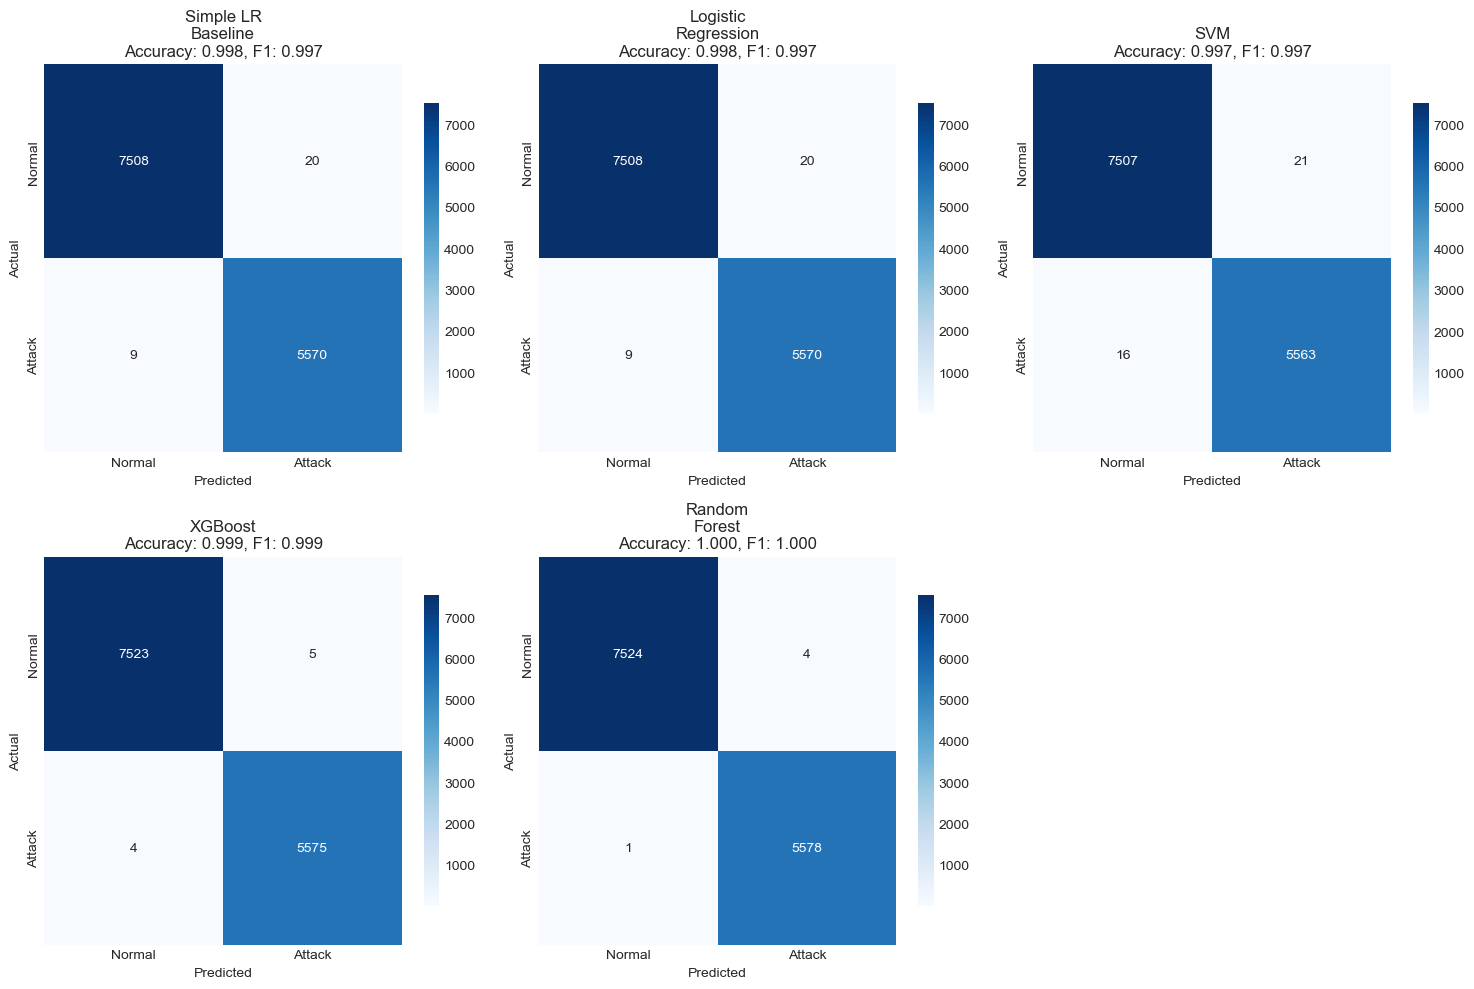

In [128]:
print("Creating Confusion Matrices Grid...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#fig.suptitle('Confusion Matrices: Model Comparison', fontsize=16, fontweight='bold')

# List of models to plot (excluding dummy for confusion matrix)
models_to_plot = ['Simple LR\nBaseline', 'Logistic\nRegression', 'SVM', 
                  'XGBoost', 'Random\nForest']

# Get confusion matrices for each model
# You'll need to calculate these from your actual predictions
confusion_matrices_list = []

# Add baseline LR confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_lr_base)
confusion_matrices_list.append(cm_baseline)

# Add optimized model confusion matrices (from Part 7)
for model_name in ['Logistic Regression', 'SVM', 'XGBoost', 'Random Forest']:
    if model_name in confusion_matrices:
        confusion_matrices_list.append(confusion_matrices[model_name])

# Plot each confusion matrix
for idx, (ax, cm, model_name) in enumerate(zip(axes.flat[:5], confusion_matrices_list, models_to_plot)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'],
                cbar_kws={'shrink': 0.8})
    
    # Calculate metrics for title
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * tp / (2 * tp + fp + fn)
    
    ax.set_title(f'{model_name}\nAccuracy: {accuracy:.3f}, F1: {f1:.3f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Hide the 6th subplot
axes.flat[5].set_visible(False)

plt.tight_layout()
plt.show()

Creating ROC Curves Comparison...


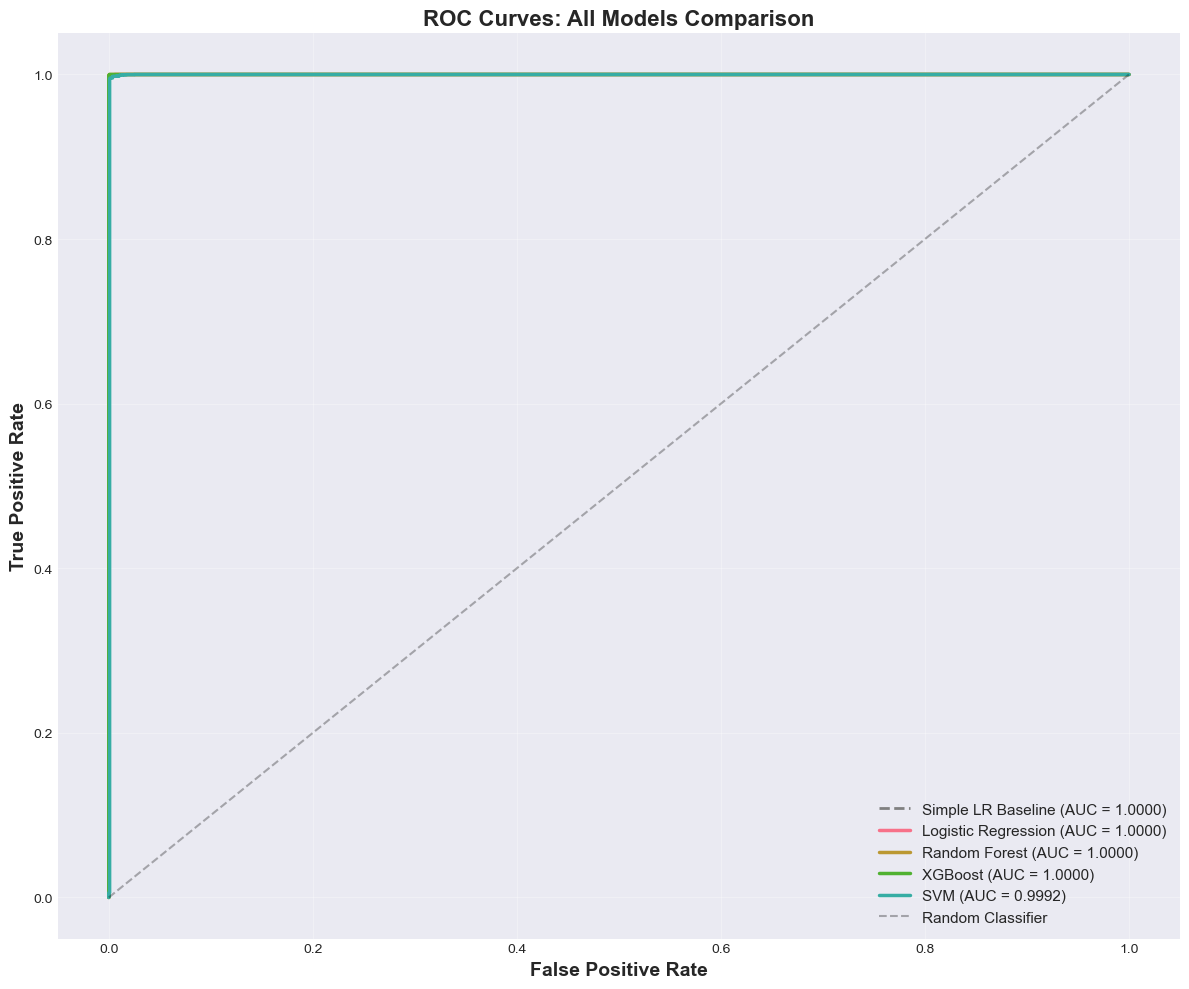

In [115]:
print("Creating ROC Curves Comparison...")

plt.figure(figsize=(12, 10))

# Plot ROC curves for each model (excluding dummy)
model_colors = {'Simple LR Baseline': 'gray', 'Logistic Regression': 'blue', 
                'Random Forest': 'green', 'XGBoost': 'purple', 'SVM': 'orange'}

# Baseline LR ROC
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_lr_base_proba)
roc_auc_base = auc(fpr_base, tpr_base)
plt.plot(fpr_base, tpr_base, color='gray', linewidth=2, 
         label=f'Simple LR Baseline (AUC = {roc_auc_base:.4f})', linestyle='--')

# Plot ROC for each optimized model
for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM']:
    if model_name in best_models:
        y_pred_proba = best_models[model_name].predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        color = model_colors.get(model_name, 'black')
        plt.plot(fpr, tpr, linewidth=2.5, 
                label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves: All Models Comparison', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Creating Class Distribution Visualizations...


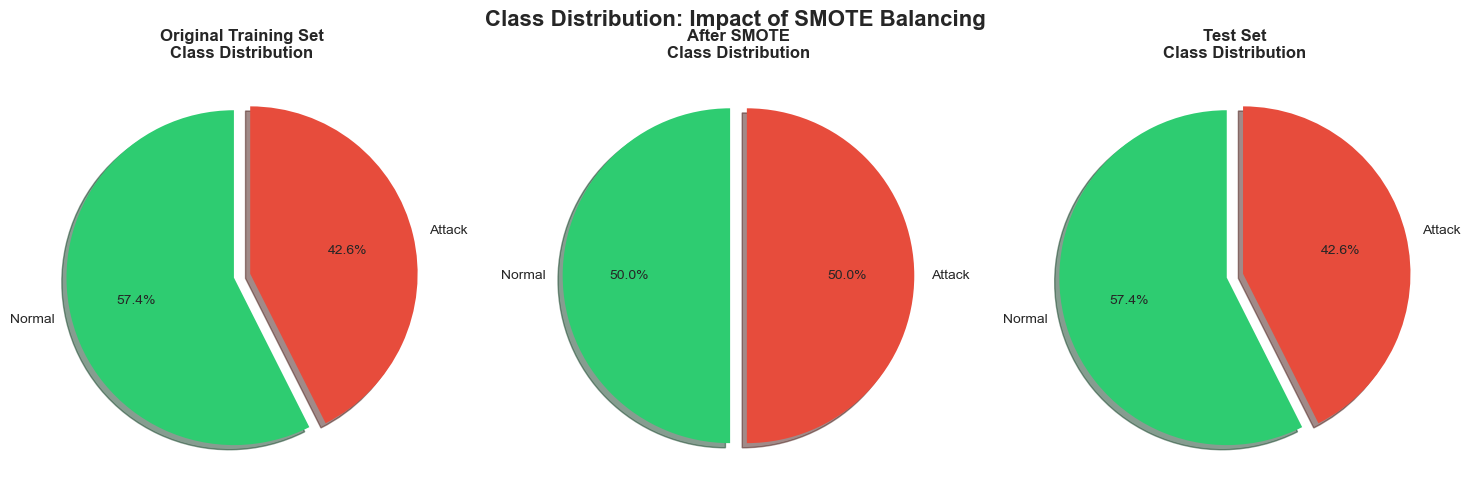

In [117]:
print("Creating Class Distribution Visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
ax1 = axes[0]
labels = ['Normal', 'Attack']
sizes_original = [(y_train == 0).sum(), (y_train == 1).sum()]
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax1.pie(sizes_original, explode=explode, labels=labels, 
                                    colors=colors, autopct='%1.1f%%',
                                    shadow=True, startangle=90)
ax1.set_title('Original Training Set\nClass Distribution', fontsize=12, fontweight='bold')

# After SMOTE
ax2 = axes[1]
sizes_balanced = [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()]
wedges, texts, autotexts = ax2.pie(sizes_balanced, explode=explode, labels=labels, 
                                    colors=colors, autopct='%1.1f%%',
                                    shadow=True, startangle=90)
ax2.set_title('After SMOTE\nClass Distribution', fontsize=12, fontweight='bold')

# Test set distribution
ax3 = axes[2]
sizes_test = [(y_test == 0).sum(), (y_test == 1).sum()]
wedges, texts, autotexts = ax3.pie(sizes_test, explode=explode, labels=labels, 
                                    colors=colors, autopct='%1.1f%%',
                                    shadow=True, startangle=90)
ax3.set_title('Test Set\nClass Distribution', fontsize=12, fontweight='bold')

plt.suptitle('Class Distribution: Impact of SMOTE Balancing', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


6. Creating Performance Metrics Comparison...


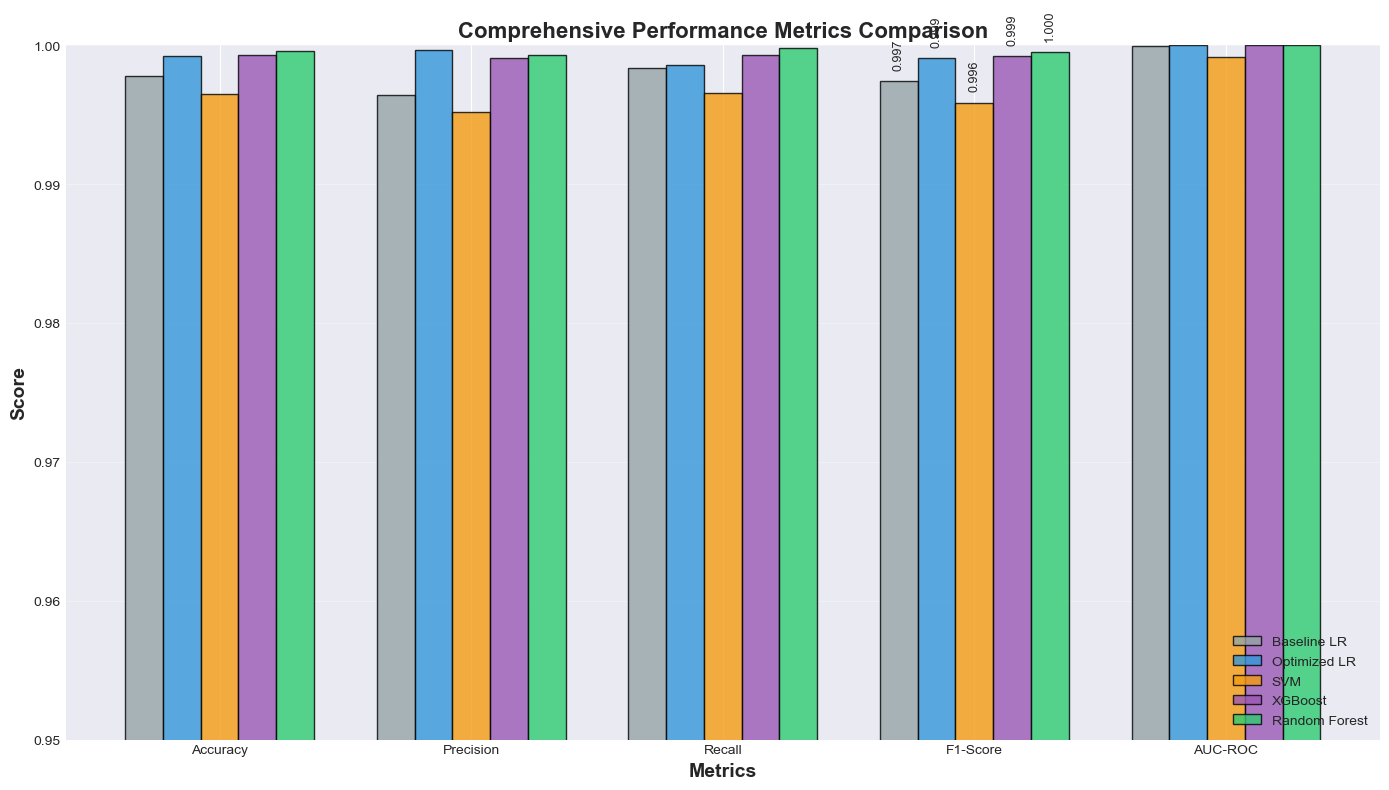

In [118]:
print("\n6. Creating Performance Metrics Comparison...")

plt.figure(figsize=(14, 8))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(metrics))
width = 0.15

# Prepare data for each model
baseline_metrics = [lr_base_accuracy, lr_base_precision, lr_base_recall, lr_base_f1, lr_base_auc]

# Get metrics for each optimized model from results_df
models_data = {}
for model in ['Logistic Regression', 'SVM', 'XGBoost', 'Random Forest']:
    model_data = results_df[results_df['Model'] == model].iloc[0]
    models_data[model] = [
        model_data['Test_Accuracy'],
        model_data['Test_Precision'],
        model_data['Test_Recall'],
        model_data['Test_F1'],
        model_data['Test_AUC']
    ]

# Plot bars for each model
plt.bar(x - 2*width, baseline_metrics, width, label='Baseline LR', 
        color='#95a5a6', alpha=0.8, edgecolor='black')
plt.bar(x - width, models_data['Logistic Regression'], width, 
        label='Optimized LR', color='#3498db', alpha=0.8, edgecolor='black')
plt.bar(x, models_data['SVM'], width, 
        label='SVM', color='#f39c12', alpha=0.8, edgecolor='black')
plt.bar(x + width, models_data['XGBoost'], width, 
        label='XGBoost', color='#9b59b6', alpha=0.8, edgecolor='black')
plt.bar(x + 2*width, models_data['Random Forest'], width, 
        label='Random Forest', color='#2ecc71', alpha=0.8, edgecolor='black')

plt.xlabel('Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.title('Comprehensive Performance Metrics Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, metrics)
plt.legend(loc='lower right')
plt.ylim([0.95, 1.0])  # Zoom in since all scores are high
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars (only for F1-Score for clarity)
for i, metric in enumerate(metrics):
    if metric == 'F1-Score':
        # Plot baseline value
        plt.text(i - 2*width, baseline_metrics[i] + 0.001, 
                f'{baseline_metrics[i]:.3f}', 
                ha='center', fontsize=9, rotation=90)
        
        # Plot values for each optimized model
        for j, model_name in enumerate(['Logistic Regression', 'SVM', 'XGBoost', 'Random Forest']):
            y_val = models_data[model_name][i]
            x_offset = (j - 1) * width
            plt.text(i + x_offset, y_val + 0.001, 
                    f'{y_val:.3f}', 
                    ha='center', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

Creating Training Time Comparison...


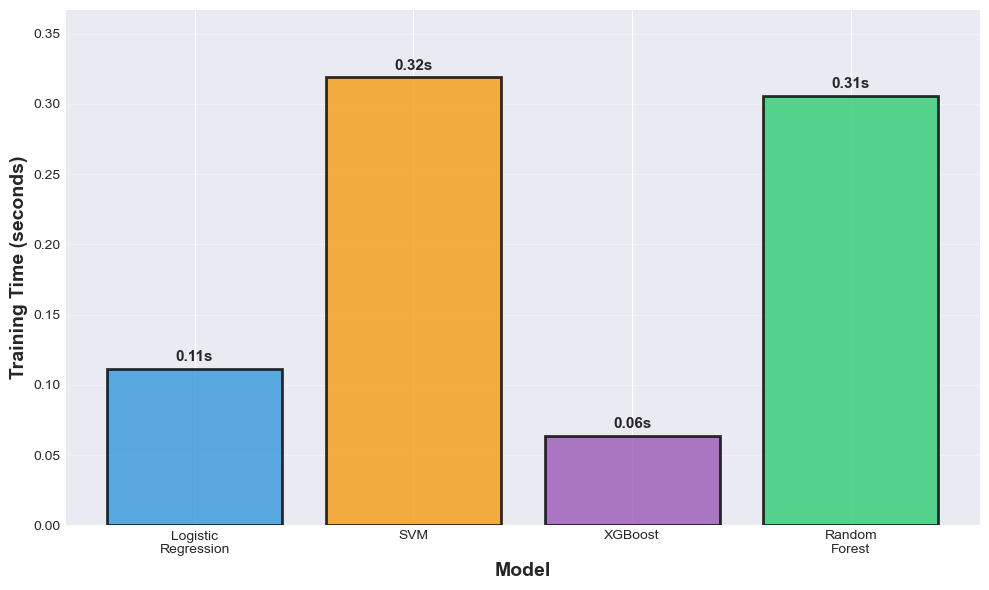

In [129]:
print("Creating Training Time Comparison...")
plt.figure(figsize=(10, 6))

# Get training times from results
models = ['Logistic\nRegression', 'SVM', 'XGBoost', 'Random\nForest']
train_times = []

# Convert results list to DataFrame if it's not already
if isinstance(results, list):
    results_df_temp = pd.DataFrame(results)
else:
    results_df_temp = results

for model in ['Logistic Regression', 'SVM', 'XGBoost', 'Random Forest']:
    # Get training time for each model
    model_time = results_df_temp[results_df_temp['Model'] == model]['Train Time (s)'].values[0]
    train_times.append(model_time)

colors = ['#3498db', '#f39c12', '#9b59b6', '#2ecc71']
bars = plt.bar(models, train_times, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Calculate y-axis limits with padding
max_time = max(train_times)
y_padding = max_time * 0.15  # Add 15% padding above the highest bar
plt.ylim(0, max_time + y_padding)

# Add value labels on top of bars
for bar, time in zip(bars, train_times):
    # Position the text slightly above each bar
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + max_time * 0.01,  # Small offset above bar
             f'{time:.2f}s', 
             ha='center', 
             va='bottom',  # Align text bottom to position
             fontsize=11, 
             fontweight='bold')

plt.ylabel('Training Time (seconds)', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
#plt.title('Model Training Time Comparison', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## FINAL SUMMARY

In this project, I developed and evaluated machine learning models to classify network traffic as normal or malicious using a firewall log dataset containing 65,532 records and 12 original features. The dataset was nearly balanced (43% attack traffic), enabling fair evaluation across metrics.

### Data Preprocessing & Feature Engineering
- Applied data cleaning to remove irrelevant or duplicate entries.
- Performed feature engineering, expanding from 12 to 32 features, including derived metrics such as bytes_per_second, packets_per_second, and protocol flags.
- Used SMOTE to handle class imbalance during training by generating synthetic minority class samples.
- Applied scaling (StandardScaler) within a Pipeline to ensure transformations occurred only on training folds, preventing data leakage.

### Modeling
I trained and tuned four models using GridSearchCV with stratified 5-fold cross-validation:
- Logistic Regression – baseline linear model for interpretability.
- Random Forest – ensemble of decision trees using majority voting.
- XGBoost – gradient boosting with tree learners, iteratively improving from prior errors.
- SVM (RBF kernel) – maximizes the decision margin in transformed feature space for nonlinear separation.

Hyperparameters (e.g., tree depth, learning rate, regularization) were tuned to optimize F1-score on the validation folds.

### Evaluation
- Metrics: Accuracy, Precision, Recall, and F1-score.
- Stratified 5-fold CV ensured consistent class ratios and reduced variance from random splits.
- Training, CV, and test results were consistent, indicating minimal overfitting.
- Feature importance was extracted from Random Forest and XGBoost; for LR and SVM, permutation importance was suggested for future work.

### Key Findings
- XGBoost achieved the highest overall F1-score and inference speed, outperforming Random Forest and SVM.
- Scaling improved Logistic Regression performance and helped mitigate multicollinearity effects.
- Pipelines ensured reproducible preprocessing and prevented leakage.

### Conclusion & Future Work
The project demonstrates that ensemble methods, particularly XGBoost, are effective for intrusion detection on balanced firewall log data.
Future improvements include:
- Testing model generalization on external datasets from different networks.
- Applying permutation importance or SHAP for all models to understand feature impacts uniformly.
- Exploring incremental learning to address concept drift in evolving network traffic.